In [236]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

In [237]:
def get_run_df(run_id, metric, interval=10):
    """Fetch W&B history and return downsampled DataFrame."""
    api = wandb.Api()
    run_path = f"zihanwang-ai-northwestern-university/ragen_latest/{run_id}"
    run = api.run(run_path)
    # breakpoint()
    df = pd.DataFrame(run.history(keys=["_step", metric]))
    df = df[df['_step'] % interval == 0]
    return df

In [244]:
import yaml
import pandas as pd
from pathlib import Path

with open(Path.cwd() / "experiment_runids.yaml", "r") as fp:
    EXPERIMENTS = yaml.safe_load(fp)["experiments"]

METRIC_KEY_MAP = {
    "success_rate": {
        "webshop": "train/WebShop/success",
        "bandit": "train/Bandit/success",
        "frozenlake_coord": "train/CoordFrozenLake/success",
        "sokoban_coord": "train/CoordSokoban/success",
    },
    "train_reward": {
        "webshop": "train/WebShop/traj_sum/reward",
        "bandit": "train/Bandit/success",
        "frozenlake_coord": "train/CoordFrozenLake/success",
        "sokoban_coord": "train/CoordSokoban/success",
    },
    "test_reward": {
        "webshop": "val-env/WebShop/traj_sum/reward",
        "bandit": "val-env/BanditTest/success",
        "frozenlake_coord": "val-env/CoordFrozenLake/success",
        "sokoban_coord": "val-env/CoordSokoban/success",
    },
    "rollout_reward_std": {"*": "rollout/chosen_in_group_reward_std"},
    "entropy": {"*": "actor/entropy"},
    "grad_norm": {"*": "actor/grad_norm"},
}

META_FIELDS = [
    "task",
    "model_size",
    "algo",
    "think",
    "starpos",
    "klcoef",
    "entropyfilter",
]

def metric_key(task: str, pretty_metric: str) -> str:
    per_task = METRIC_KEY_MAP[pretty_metric]
    task_key = task.lower()
    if task_key in per_task:
        return per_task[task_key]
    if "*" in per_task:
        return per_task["*"]
    raise KeyError(
        f"No metric mapping for task '{task}' and metric '{pretty_metric}'."
    )

def load_run_metrics(exp: dict, metric_names, interval: int = 10) -> pd.DataFrame:
    """Load all requested metrics for one run, aligned on `_step`."""
    frames = []
    missing_metrics = []

    for metric_name in metric_names:
        raw_metric = metric_key(exp["task"], metric_name)
        try:
            df = get_run_df(exp["runid"], raw_metric, interval=interval)
        except Exception as err:
            print(f"[WARN] Failed to fetch {metric_name} ({raw_metric}) for {exp['runid']}: {err}")
            missing_metrics.append(metric_name)
            continue

        if df.empty or raw_metric not in df.columns:
            print(f"[WARN] Metric {raw_metric} absent for {exp['runid']} – filling with zeros.")
            missing_metrics.append(metric_name)
            continue

        df = df.rename(columns={raw_metric: metric_name})[["_step", metric_name]]
        frames.append(df)

    if not frames:
        merged = pd.DataFrame()
    else:
        merged = frames[0]
        for df in frames[1:]:
            merged = pd.merge(merged, df, on="_step", how="outer")
        merged = merged.sort_values("_step").reset_index(drop=True)

    # ensure every metric column exists; fill missing with zeros
    for metric_name in metric_names:
        if metric_name not in merged.columns:
            merged[metric_name] = 0

    # attach metadata
    for field in META_FIELDS + ["runid"]:
        merged[field] = exp.get(field)

    return merged


def load_all_runs(experiments, metric_names, interval: int = 10) -> pd.DataFrame:
    frames = [
        load_run_metrics(exp, metric_names, interval=interval)
        for exp in experiments
    ]
    frames = [df for df in frames if not df.empty]
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

# TARGET_METRICS = [
#     "success_rate",
#     "train_reward",
#     "test_reward",
#     "rollout_reward_std",
#     "entropy",
#     "grad_norm",
# ]
TARGET_METRICS = METRIC_KEY_MAP.keys()

all_runs_df = load_all_runs(EXPERIMENTS, TARGET_METRICS, interval=10)
all_runs_df.head()


[WARN] Failed to fetch rollout_reward_std (rollout/chosen_in_group_reward_std) for bandit_3b_base_ppo_think_s_entropyfilter_1: '_step'
[WARN] Failed to fetch train_reward (train/Bandit/success) for bandit_3b_base_grpo_think_normal_1: An error occurred while verifying the API key.
[WARN] Failed to fetch test_reward (val-env/BanditTest/success) for bandit_3b_base_grpo_think_normal_1: An error occurred while verifying the API key.
[WARN] Failed to fetch rollout_reward_std (rollout/chosen_in_group_reward_std) for webshop_3b_base_ppo_think_s_entropyfilter: '_step'
[WARN] Failed to fetch rollout_reward_std (rollout/chosen_in_group_reward_std) for sokoban_coord_3b_base_ppo_think_s_entropyfilter_1: '_step'
[WARN] Failed to fetch rollout_reward_std (rollout/chosen_in_group_reward_std) for frozenlake_coord_3b_base_ppo_think_s_entvarfilter: '_step'


,_step,success_rate,train_reward,test_reward,rollout_reward_std,entropy,grad_norm,task,model_size,algo,think,starpos,klcoef,entropyfilter,runid
0,0,NaN,NaN,0.630859,NaN,NaN,NaN,bandit,3b,ppo,True,False,0.0,False,bandit_3b_base_ppo_think_normal_2
1,10,0.359375,0.359375,0.632812,0.227269,1.652174,6.408571,bandit,3b,ppo,True,False,0.0,False,bandit_3b_base_ppo_think_normal_2
2,20,0.585938,0.585938,0.685547,0.375849,1.388950,4.989334,bandit,3b,ppo,True,False,0.0,False,bandit_3b_base_ppo_think_normal_2
3,30,0.625000,0.625000,0.714844,0.359057,1.261767,5.685498,bandit,3b,ppo,True,False,0.0,False,bandit_3b_base_ppo_think_normal_2
4,40,0.617188,0.617188,0.685547,0.299544,1.139434,5.190385,bandit,3b,ppo,True,False,0.0,False,bandit_3b_base_ppo_think_normal_2


In [ ]:
all_runs_df_orig = all_runs_df.copy()
all_runs_df.groupby(["task", "starpos", "algo", "think"])["_step"].count()

In [246]:
def normalize_starpos_steps(df: pd.DataFrame) -> pd.DataFrame:
    """
    For starpos=True rows, halve _step (integer division) and
    keep only rows where the resulting _step is divisible by 10.
    """
    out = df.copy()
    mask = out["starpos"] == True
    out.loc[mask, "_step"] = out.loc[mask, "_step"] // 2
    out["_step"] = out["_step"].astype(int)
    out = out[out["_step"] % 10 == 0]
    return out.reset_index(drop=True)

# Usage:
all_runs_df = normalize_starpos_steps(all_runs_df)

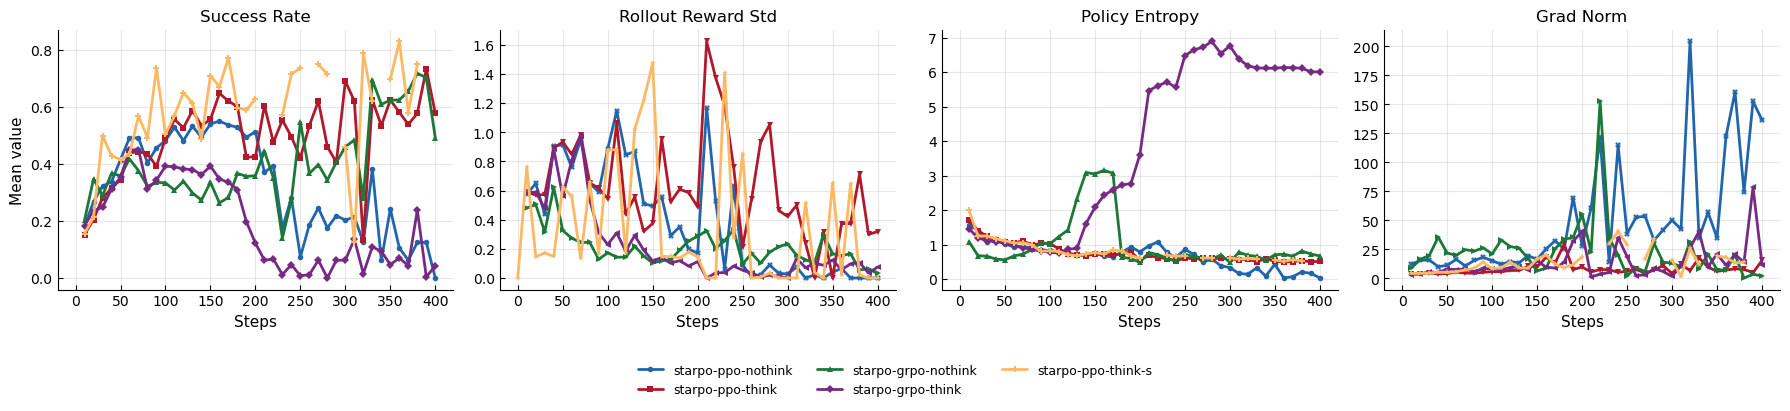

In [250]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "legend.frameon": False,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "lines.solid_capstyle": "round",
})

METRIC_COLUMNS = [
    ("success_rate", "Success Rate"),
    ("rollout_reward_std", "Rollout Reward Std"),
    ("entropy", "Policy Entropy"),
    ("grad_norm", "Grad Norm"),
]

conditions = [
    {
        "label": "starpo-ppo-nothink",
        "mask": (
            (all_runs_df["starpos"] == False) &
            (all_runs_df["algo"] == "ppo") &
            (all_runs_df["think"] == False)
        ),
        "color": "#2166ac",
    },
    {
        "label": "starpo-ppo-think",
        "mask": (
            (all_runs_df["starpos"] == False) &
            (all_runs_df["algo"] == "ppo") &
            (all_runs_df["think"] == True)
        ),
        "color": "#b2182b",
    },
    {
        "label": "starpo-grpo-nothink",
        "mask": (
            (all_runs_df["starpos"] == False) &
            (all_runs_df["algo"] == "grpo") &
            (all_runs_df["think"] == False)
        ),
        "color": "#1b7837",
    },
    {
        "label": "starpo-grpo-think",
        "mask": (
            (all_runs_df["starpos"] == False) &
            (all_runs_df["algo"] == "grpo") &
            (all_runs_df["think"] == True)
        ),
        "color": "#762a83",
    },
    {
        "label": "starpo-ppo-think-s",
        "mask": (
            (all_runs_df["starpos"] == True) &
            (all_runs_df["algo"] == "ppo") &
            (all_runs_df["think"] == True) &
            (all_runs_df["runid"].str.contains("_think_s"))
        ),
        "color": "#fdb863",
    },
]

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(METRIC_COLUMNS),
    figsize=(4.5 * len(METRIC_COLUMNS), 3.5),
    sharex=True,
)

marker_cycle = cycle(['o', 's', '^', 'D', 'P', 'X', 'v', '>', '<', '*'])

for ax, (metric_key, metric_title) in zip(axes, METRIC_COLUMNS):
    ax.set_title(metric_title)
    for cond in conditions:
        subset = all_runs_df[cond["mask"]]
        if subset.empty or metric_key not in subset:
            continue

        grouped_mean = (
            subset.groupby("_step")[metric_key]
                  .mean()
                  .sort_index()
        )

        marker = next(marker_cycle)
        ax.plot(
            grouped_mean.index,
            grouped_mean.values,
            label=cond["label"],
            color=cond["color"],
            linestyle="-",
            linewidth=2,
            marker=marker,
            markersize=4,
            markerfacecolor=cond["color"],
            markeredgecolor=cond["color"],
            markeredgewidth=0.0,
        )

    ax.set_xlabel("Steps")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Mean value")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, -0.18),
    fontsize=9,
)
plt.tight_layout(rect=[0, 0.0, 1, 1])
plt.show()


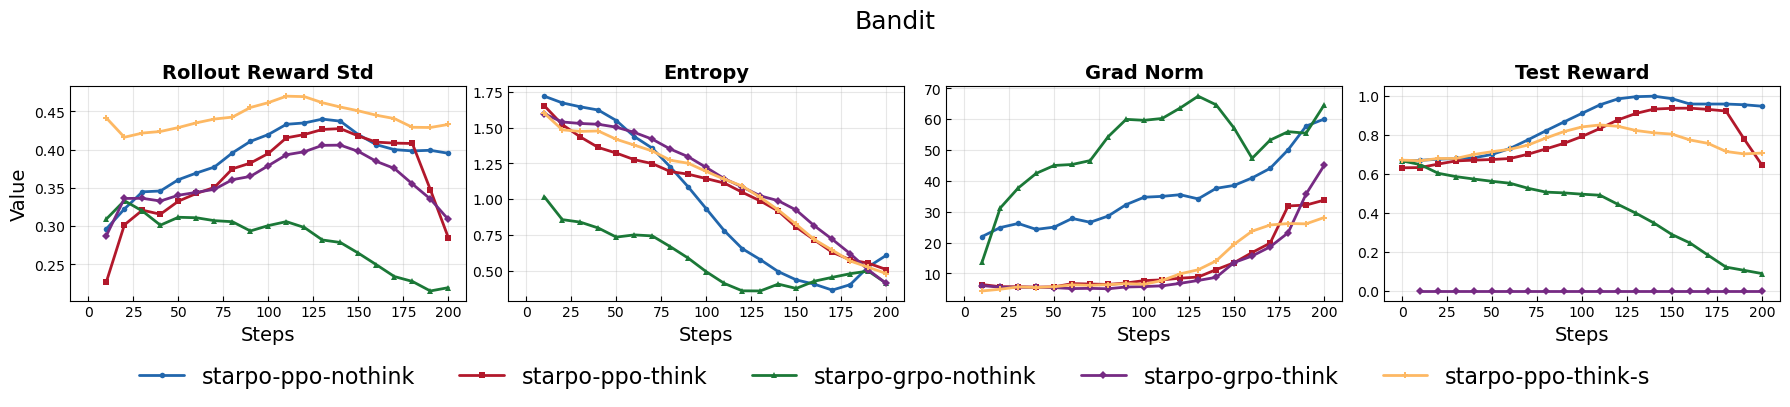

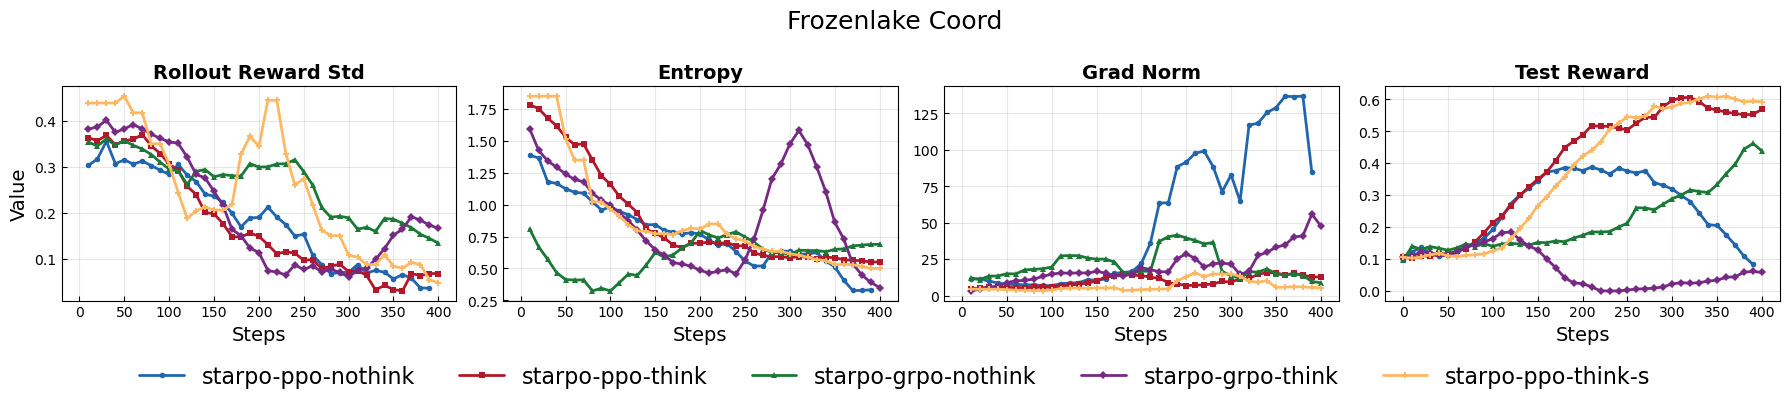

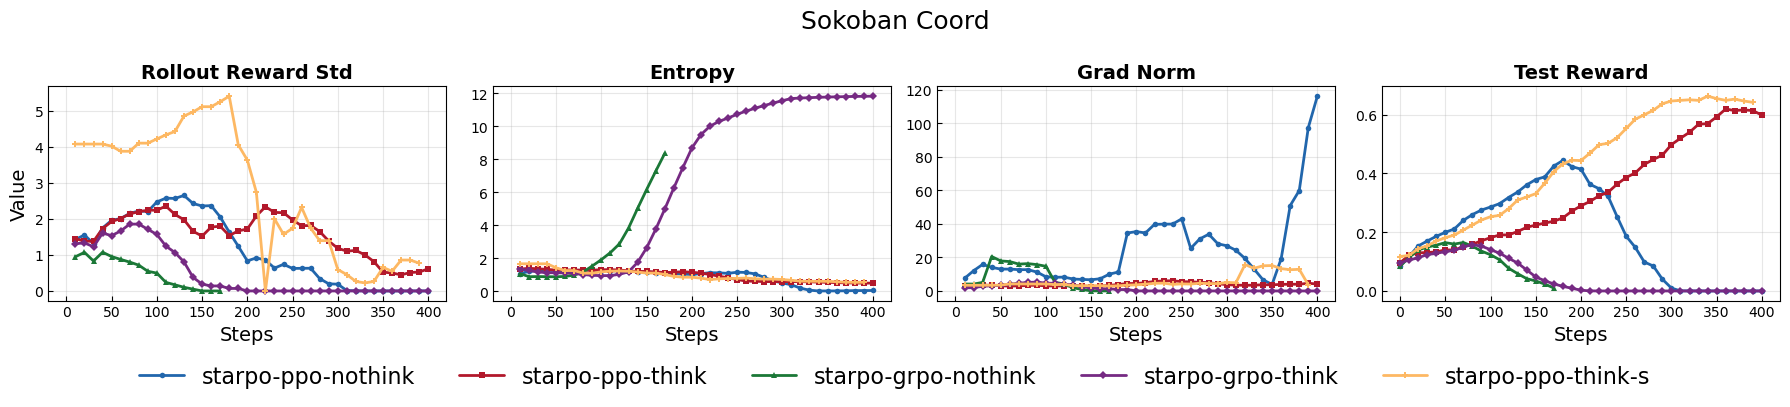

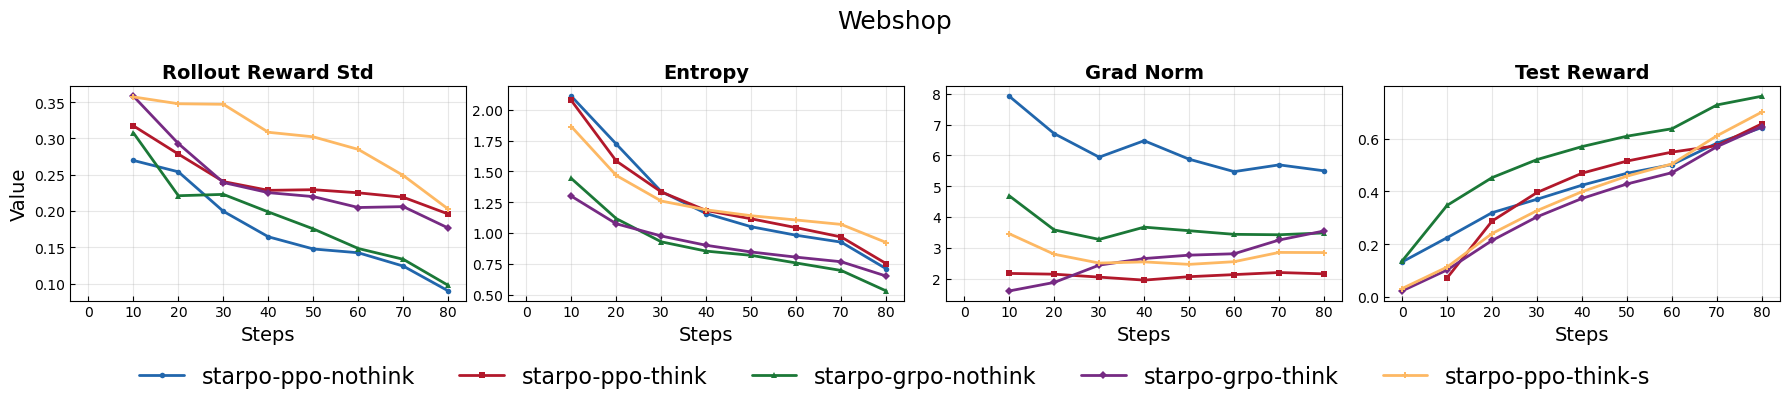

In [283]:
import matplotlib.pyplot as plt
from itertools import cycle

SMOOTHING_WINDOW = 7  # set to None or <=1 to disable

def smooth_series(series, window):
    if not window or window <= 1:
        return series
    return series.rolling(window, min_periods=1).mean()

METRIC_COLUMNS = [
    # ("train_reward", "Train Reward"),
    ("rollout_reward_std", "Rollout Reward Std"),
    ("entropy", "Entropy"),
    ("grad_norm", "Grad Norm"),
    ("test_reward", "Test Reward"),
]

conditions = [
    {
        "label": "starpo-ppo-nothink",
        "color": "#2166ac",
        "selector": lambda df: (
            (df["starpos"] == False) &
            (df["algo"] == "ppo") &
            (df["think"] == False) &
            (df["entropyfilter"] == False) &
            (df["klcoef"] == 0)
        ),
    },
    {
        "label": "starpo-ppo-think",
        "color": "#b2182b",
        "selector": lambda df: (
            (df["starpos"] == False) &
            (df["algo"] == "ppo") &
            (df["think"] == True) &
            (df["entropyfilter"] == False) &
            (df["klcoef"] == 0)
        ),
    },
    {
        "label": "starpo-grpo-nothink",
        "color": "#1b7837",
        "selector": lambda df: (
            (df["starpos"] == False) &
            (df["algo"] == "grpo") &
            (df["think"] == False) &
            (df["entropyfilter"] == False) &
            (df["klcoef"] == 0)
        ),
    },
    {
        "label": "starpo-grpo-think",
        "color": "#762a83",
        "selector": lambda df: (
            (df["starpos"] == False) &
            (df["algo"] == "grpo") &
            (df["think"] == True) &
            (df["entropyfilter"] == False) &
            (df["klcoef"] == 0)
        ),
    },
    {
        "label": "starpo-ppo-think-s",
        "color": "#fdb863",
        "selector": lambda df: (
            (df["starpos"] == True) &
            (df["algo"] == "ppo") &
            (df["think"] == True) &
            (df["entropyfilter"] == False) &
            (df["klcoef"] == 0)
        ),
    },
]

plt.rcParams.update({
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "legend.frameon": False,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "lines.solid_capstyle": "round",
})

MAX_STEPS = {
    "bandit": 200,
    "webshop": 80,
    "frozenlake_coord": 400,
    "sokoban_coord": 400,
}

task_order = sorted(all_runs_df["task"].unique())

for task in task_order:
    task_df = all_runs_df[all_runs_df["task"] == task].copy()
    if task_df.empty:
        continue

    max_step = MAX_STEPS.get(task)
    task_df = task_df[task_df["_step"] <= max_step].copy()

    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(METRIC_COLUMNS),
        figsize=(4.5 * len(METRIC_COLUMNS), 3.5),
        sharex=True,
    )

    for ax, (metric_key, metric_title) in zip(axes, METRIC_COLUMNS):
        ax.set_title(metric_title, fontweight=600, fontsize=14)
        marker_cycle = cycle(['o', 's', '^', 'D', 'P', 'X', 'v', '>', '<', '*'])

        for cond in conditions:
            mask = cond["selector"](task_df)
            subset = task_df[mask].sort_values("_step")
            if subset.empty or metric_key not in subset:
                print(f"[WARN] No data for {cond['label']} on task {task}")
                continue

            smoothed = smooth_series(subset[metric_key], SMOOTHING_WINDOW)
            marker = next(marker_cycle)

            ax.plot(
                subset["_step"],
                smoothed,
                label=cond["label"],
                color=cond["color"],
                linestyle="-",
                linewidth=2,
                marker=marker,
                markersize=4,
                markerfacecolor=cond["color"],
                markeredgecolor=cond["color"],
                markeredgewidth=0.0,
            )

        ax.set_xlabel("Steps", fontweight="medium", fontsize=14)
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Value", fontweight="medium", fontsize=14)
    fig.suptitle(task.replace("_", " ").title(), y=1, fontsize=18)

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(
            handles, labels,
            loc="lower center",
            ncol=5,
            frameon=False,
            bbox_to_anchor=(0.5, -0.14),
            fontsize=30,
            prop={"weight": "medium", "size": 16},
        )
    plt.tight_layout(rect=[0, 0.0, 1, 1])
    plt.savefig(f"figs/{task}_all_metrics_4.pdf", format="pdf", bbox_inches="tight")
    plt.show()


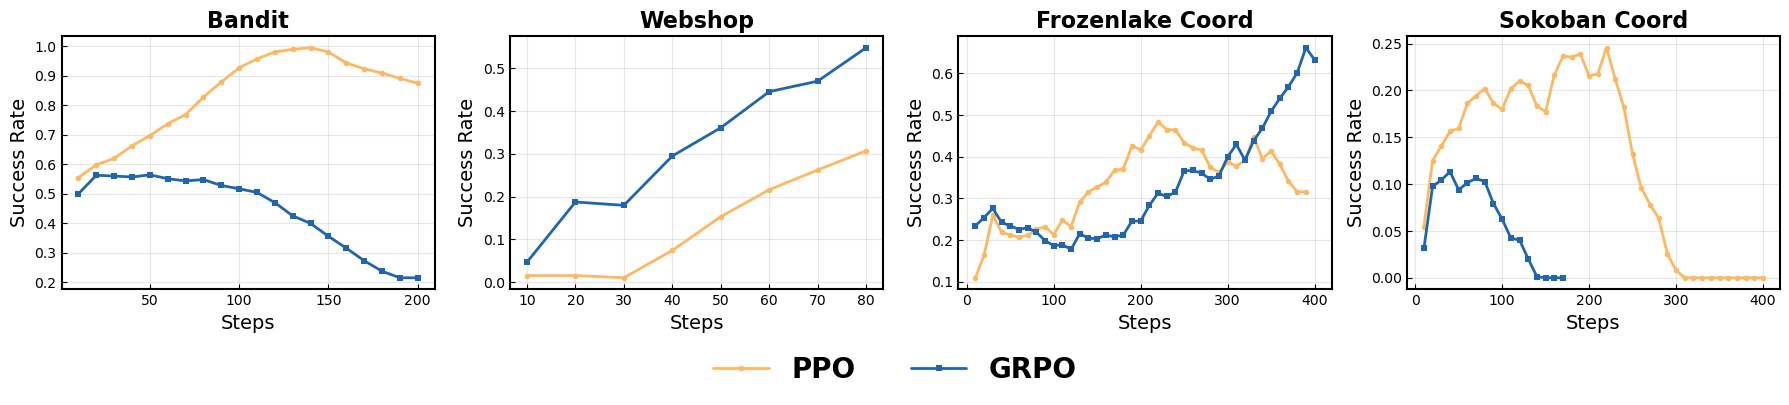

In [276]:
import matplotlib.pyplot as plt
from itertools import cycle  # already imported above; safe to reuse

SMOOTHING_WINDOW = 7  # keep whatever value you prefer

tasks = ["bandit", "webshop", "frozenlake_coord", "sokoban_coord"]
algo_specs = [
    ("ppo", "#fdb863"),
    ("grpo", "#2166ac"), # medium sky blue
]

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(tasks),
    figsize=(4.5 * len(tasks), 3.6),
    sharey=False,
    sharex=False,
)

for ax, task in zip(axes, tasks):
    task_df = all_runs_df[
        (all_runs_df["task"] == task)
        & (all_runs_df["starpos"] == False)
        & (all_runs_df["think"] == False)
        & (all_runs_df["entropyfilter"] == False)
        & (all_runs_df["klcoef"] == 0)
    ].copy()

    if task not in MAX_STEPS:
        raise KeyError(f"Missing max-step entry for task '{task}' in MAX_STEPS dict.")
    task_df = task_df[task_df["_step"] <= MAX_STEPS[task]].sort_values("_step")

    marker_cycle = cycle(['o', 's', '^', 'D', 'P', 'X', 'v', '>', '<', '*'])

    for algo_name, color in algo_specs:
        subset = task_df[task_df["algo"] == algo_name]
        if subset.empty:
            print(f"[WARN] No {algo_name} runs for task '{task}' after filtering.")
            continue

        smoothed = smooth_series(subset["success_rate"], SMOOTHING_WINDOW)
        marker = next(marker_cycle)

        ax.plot(
            subset["_step"],
            smoothed,
            label=algo_name.upper(),
            color=color,
            linestyle="-",
            linewidth=2,
            marker=marker,
            markersize=4,
            markerfacecolor=color,
            markeredgecolor=color,
            markeredgewidth=0.0,
        )

    ax.set_title(task.replace("_", " ").title(), fontweight="bold", fontsize=16)
    ax.set_xlabel("Steps", fontweight="medium", fontsize=14)
    ax.set_ylabel("Success Rate", fontweight="medium", fontsize=14)
    ax.grid(True, alpha=0.3)

    # solid border on each subplot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(
        handles, labels,
        loc="lower center",
        ncol=len(algo_specs),
        frameon=False,
        bbox_to_anchor=(0.5, -0.15),
        prop={"weight": "bold", "size": 20},
    )

plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.savefig("figs/ppo_vs_grpo_success_rate.pdf", format="pdf", bbox_inches="tight")
plt.show()


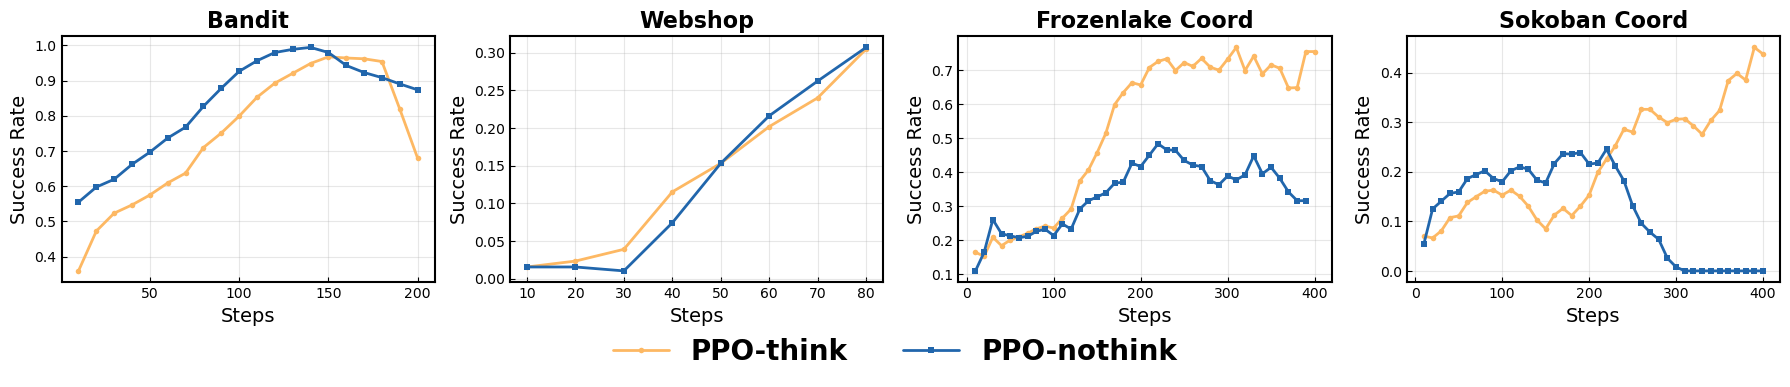

In [278]:


import matplotlib.pyplot as plt
from itertools import cycle

SMOOTHING_WINDOW = 7  # set to None or <=1 to disable smoothing

def smooth_series(series, window):
    if not window or window <= 1:
        return series
    return series.rolling(window, min_periods=1).mean()

tasks = ["bandit", "webshop", "frozenlake_coord", "sokoban_coord"]
MAX_STEPS = {
    "bandit": 200,
    "webshop": 80,
    "frozenlake_coord": 400,
    "sokoban_coord": 400,
}

# (algo, think_flag, label, color)
conditions = [
    ("ppo", True, "PPO-think", "#fdb863"),
    ("ppo", False,  "PPO-nothink",    "#2166ac"),
    # ("grpo", False, "GRPO • No Think", "#b2182b"),
    # ("grpo", True,  "GRPO • Think",    "#2166ac"),
]

plt.rcParams.update({
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "legend.frameon": False,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "lines.solid_capstyle": "round",
})

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(tasks),
    figsize=(4.5 * len(tasks), 3.6),
    sharey=False,
    sharex=False,
)

for ax, task in zip(axes, tasks):
    task_df = all_runs_df[
        (all_runs_df["task"] == task)
        & (all_runs_df["starpos"] == False)
        & (all_runs_df["entropyfilter"] == False)
        & (all_runs_df["klcoef"] == 0)
    ].copy()

    if task not in MAX_STEPS:
        raise KeyError(f"Missing max-step entry for task '{task}'.")
    task_df = task_df[task_df["_step"] <= MAX_STEPS[task]].sort_values("_step")

    marker_cycle = cycle(['o', 's', '^', 'D', 'P', 'X', 'v', '>', '<', '*'])

    for algo_name, think_flag, label, color in conditions:
        subset = task_df[
            (task_df["algo"] == algo_name) &
            (task_df["think"] == think_flag)
        ]
        if subset.empty:
            print(f"[WARN] No {label} runs for task '{task}' after filtering.")
            continue

        smoothed = smooth_series(subset["success_rate"], SMOOTHING_WINDOW)
        marker = next(marker_cycle)

        ax.plot(
            subset["_step"],
            smoothed,
            label=label,
            color=color,
            linestyle="-",
            linewidth=2,
            marker=marker,
            markersize=4,
            markerfacecolor=color,
            markeredgecolor=color,
            markeredgewidth=0.0,
        )

    ax.set_title(task.replace("_", " ").title(), fontweight="bold", fontsize=16)
    ax.set_xlabel("Steps", fontweight="medium", fontsize=14)
    ax.set_ylabel("Success Rate", fontweight="medium", fontsize=14)
    ax.grid(True, alpha=0.3)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(
        handles, labels,
        loc="lower center",
        ncol=2,
        frameon=False,
        bbox_to_anchor=(0.5, -0.1),
        prop={"weight": "bold", "size": 20},
    )

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig("figs/ppo_think_vs_nothink_success_rate.pdf", format="pdf", bbox_inches="tight")
plt.show()



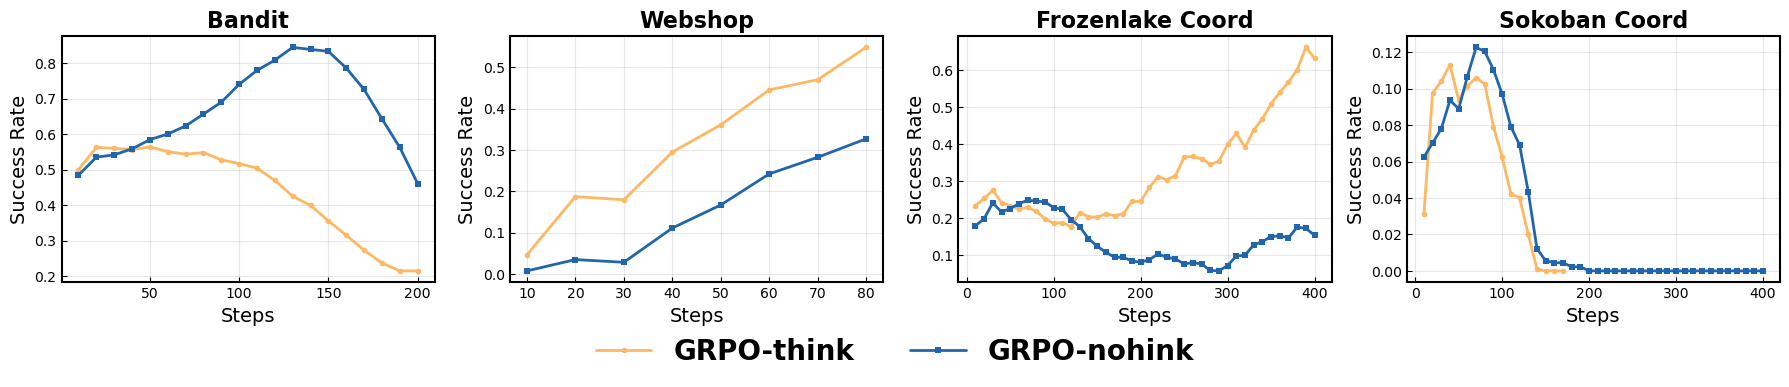

In [279]:


import matplotlib.pyplot as plt
from itertools import cycle

SMOOTHING_WINDOW = 7  # set to None or <=1 to disable smoothing

def smooth_series(series, window):
    if not window or window <= 1:
        return series
    return series.rolling(window, min_periods=1).mean()

tasks = ["bandit", "webshop", "frozenlake_coord", "sokoban_coord"]
MAX_STEPS = {
    "bandit": 200,
    "webshop": 80,
    "frozenlake_coord": 400,
    "sokoban_coord": 400,
}

# (algo, think_flag, label, color)
conditions = [
    # ("ppo", True, "PPO-think", "#fdb863"),
    # ("ppo", False,  "PPO-nothink",    "#2166ac"),
    ("grpo", False, "GRPO-think", "#fdb863"),
    ("grpo", True,  "GRPO-nohink",    "#2166ac"),
]

plt.rcParams.update({
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "legend.frameon": False,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "lines.solid_capstyle": "round",
})

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(tasks),
    figsize=(4.5 * len(tasks), 3.6),
    sharey=False,
    sharex=False,
)

for ax, task in zip(axes, tasks):
    task_df = all_runs_df[
        (all_runs_df["task"] == task)
        & (all_runs_df["starpos"] == False)
        & (all_runs_df["entropyfilter"] == False)
        & (all_runs_df["klcoef"] == 0)
    ].copy()

    if task not in MAX_STEPS:
        raise KeyError(f"Missing max-step entry for task '{task}'.")
    task_df = task_df[task_df["_step"] <= MAX_STEPS[task]].sort_values("_step")

    marker_cycle = cycle(['o', 's', '^', 'D', 'P', 'X', 'v', '>', '<', '*'])

    for algo_name, think_flag, label, color in conditions:
        subset = task_df[
            (task_df["algo"] == algo_name) &
            (task_df["think"] == think_flag)
        ]
        if subset.empty:
            print(f"[WARN] No {label} runs for task '{task}' after filtering.")
            continue

        smoothed = smooth_series(subset["success_rate"], SMOOTHING_WINDOW)
        marker = next(marker_cycle)

        ax.plot(
            subset["_step"],
            smoothed,
            label=label,
            color=color,
            linestyle="-",
            linewidth=2,
            marker=marker,
            markersize=4,
            markerfacecolor=color,
            markeredgecolor=color,
            markeredgewidth=0.0,
        )

    ax.set_title(task.replace("_", " ").title(), fontweight="bold", fontsize=16)
    ax.set_xlabel("Steps", fontweight="medium", fontsize=14)
    ax.set_ylabel("Success Rate", fontweight="medium", fontsize=14)
    ax.grid(True, alpha=0.3)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(
        handles, labels,
        loc="lower center",
        ncol=2,
        frameon=False,
        bbox_to_anchor=(0.5, -0.1),
        prop={"weight": "bold", "size": 20},
    )

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig("figs/grpo_think_vs_nothink_success_rate.pdf", format="pdf", bbox_inches="tight")
plt.show()



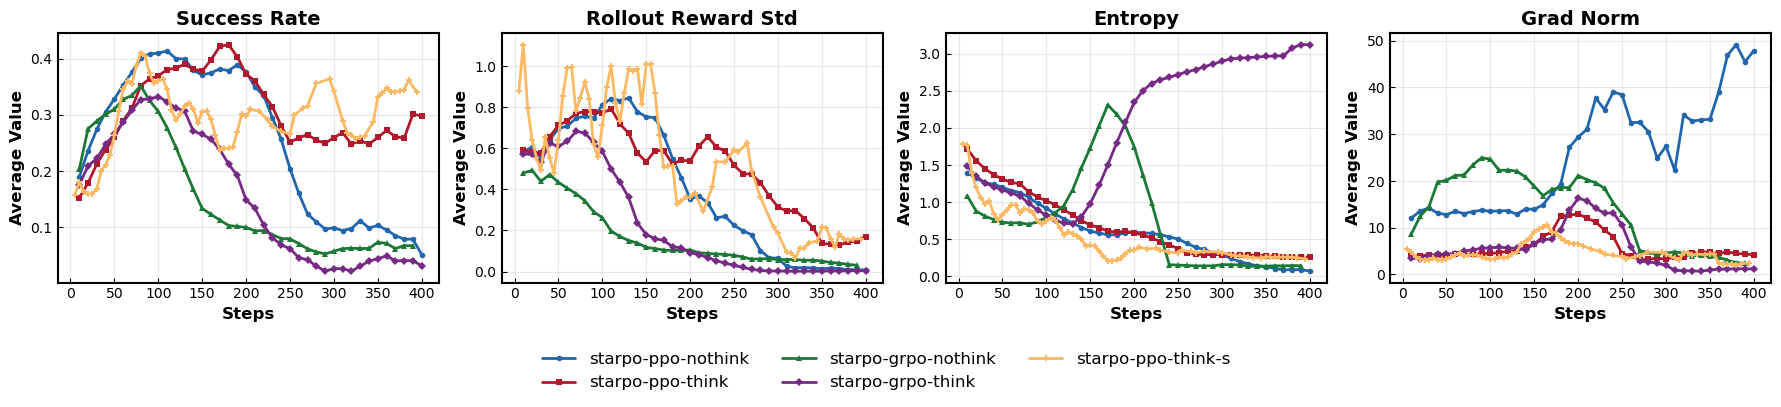

In [201]:
import matplotlib.pyplot as plt
from itertools import cycle

SMOOTHING_WINDOW = 7  # keep whatever value you like

metrics = [
    ("success_rate", "Success Rate"),
    ("rollout_reward_std", "Rollout Reward Std"),
    ("entropy", "Entropy"),
    ("grad_norm", "Grad Norm"),
]

tasks = ["bandit", "webshop", "frozenlake_coord", "sokoban_coord"]
num_tasks = len(tasks)

def aggregate_condition(metric_key, selector):
    """Sum the per-task series and divide by number of tasks."""
    per_task = []
    for task in tasks:
        task_df = all_runs_df[
            (all_runs_df["task"] == task)
            & selector(all_runs_df)  # selector checks algo/think/etc.
        ].copy()
        if task not in MAX_STEPS:
            raise KeyError(f"No MAX_STEPS entry for task '{task}'.")
        task_df = task_df[task_df["_step"] <= MAX_STEPS[task]]
        task_df = task_df.sort_values("_step")
        if task_df.empty or metric_key not in task_df:
            per_task.append(pd.Series(dtype=float))
            continue
        per_task.append(
            task_df.set_index("_step")[metric_key]
        )

    if not per_task:
        return pd.Series(dtype=float)

    aligned = pd.concat(per_task, axis=1).fillna(0.0)
    aggregated = aligned.sum(axis=1) / num_tasks
    return aggregated.sort_index()

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(metrics),
    figsize=(4.5 * len(metrics), 3.6),
    sharex=False,
    sharey=False,
)

for ax, (metric_key, metric_title) in zip(axes, metrics):
    ax.set_title(metric_title, fontweight="semibold", fontsize=14)
    marker_cycle = cycle(['o', 's', '^', 'D', 'P', 'X', 'v', '>', '<', '*'])

    for cond in conditions:
        aggregated = aggregate_condition(metric_key, cond["selector"])
        if aggregated.empty:
            print(f"[WARN] No data for {cond['label']} across tasks.")
            continue

        smoothed = smooth_series(aggregated, SMOOTHING_WINDOW)
        marker = next(marker_cycle)

        ax.plot(
            smoothed.index,
            smoothed.values,
            label=cond["label"],
            color=cond["color"],
            linestyle="-",
            linewidth=2,
            marker=marker,
            markersize=4,
            markerfacecolor=cond["color"],
            markeredgecolor=cond["color"],
            markeredgewidth=0.0,
        )

    ax.set_xlabel("Steps", fontweight="bold", fontsize=12)
    ax.set_ylabel("Average Value", fontweight="bold", fontsize=12)
    ax.grid(True, alpha=0.3)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(
        handles, labels,
        loc="lower center",
        ncol=3,
        frameon=False,
        bbox_to_anchor=(0.5, -0.14),
        prop={"weight": "medium", "size": 12},
    )

plt.tight_layout(rect=[0, 0.05, 1, 1])
# plt.savefig("figs/task_average_metrics.pdf", format="pdf")
plt.show()
